# Иницилизация

In [0]:

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file = drive.CreateFile({'id': "1w4dZoMmDaawyLnGoa69dAY2cp7DPsvG1"})
file.GetContentFile("augDataset.zip")
!unzip -uq "augDataset.zip" -d ""

file = drive.CreateFile({'id': "10XZ0W2Sq7HXl06H-M3vAGSgIffhHy5U6"})
file.GetContentFile("centeredDataset.zip")
!unzip -uq "centeredDataset.zip" -d ""
!ls

adc.json	centeredDataset.zip  experement_12.zip	uniondatasetAugment
augDataset.zip	experement_12	     sample_data	uniondatasetCentered


# Константы

In [0]:
import random
RANDOM_SEED = 87118956 #random.randint(0, 99999999)

DATASET_NAME = "[Dynamic Hand Gesture 14/28 dataset](http://www-rech.telecom-lille.fr/DHGdataset/) + [SHREC’17 Track Dataset](http://www-rech.telecom-lille.fr/shrec2017-hand/) координаты костей в пространстве + агуметация"
DATASET_AUG_ROOT = "uniondatasetAugment/"
DATASET_CENTERED_ROOT = "uniondatasetCentered/"
COUNT_GUESTURE = 14
COUNT_SAMPLES = 10000
COUNT_AUG_EPOCH = 0


DROPOUT_X = 0.5
DROPOUT_MASK = 0.5

EXPEREMENT_NAME = 'experement_13'
EXPEREMENT_PATH = './%s/'%EXPEREMENT_NAME
EPOCH_COUNT = 200
EPOCH_SIZE = 256
LEARN_RATE = 0.01


ZIP_NAME = '%s.zip'%EXPEREMENT_NAME


# Загрузка датасета

In [0]:
import pandas as pd
import numpy as np
import random
import os

from keras.utils import Sequence

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

columns = []
for i in range(22):
    columns.append("x"+str(i))
    columns.append("y"+str(i))
    columns.append("z"+str(i))

trainDataset = []
testDataset = []


minRows = None
maxRows = None

def parseData( path ):
    rawData = pd.read_csv (path, sep=",")
    data = np.array(rawData)
    data = data[1:,:]
    data = data.reshape([1, data.shape[0], data.shape[1]])
    return data

for guestureId in range(COUNT_GUESTURE):
    for sampleId in range(COUNT_SAMPLES):
        path = DATASET_CENTERED_ROOT + "gesture_%i/aug_%i_0.csv"%(guestureId, sampleId)
        if not os.path.exists(path):
            break;
        data = parseData(path)
        if random.random() > 0.3:
            trainDataset.append ([data, guestureId])
            for augEpoch in range(COUNT_AUG_EPOCH):
                path = DATASET_AUG_ROOT + "gesture_%i/aug_%i_%i.csv"%(guestureId, sampleId, augEpoch)
                data = parseData(path)
                trainDataset.append ([data, guestureId])
        else:
            testDataset.append ([data, guestureId])
    
            
class DatasetSequence(Sequence):

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        #print(idx)
        x, y = self.dataset[idx]
        resY = np.zeros((1, COUNT_GUESTURE), dtype=np.float64)
        resY[:, y] = 1.0
        return x, resY

random.shuffle(trainDataset)
trainDataset = DatasetSequence(trainDataset)
testDataset = DatasetSequence(testDataset)
print("Размер обучающей выборки: %i"%len(trainDataset))
print("Размер тестовой выборки: %i"%len(testDataset))

Размер обучающей выборки: 3951
Размер тестовой выборки: 1649


In [0]:
x, y = trainDataset[0]
x.shape

(1, 55, 66)

# Создание модели

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import BatchNormalization
from keras.layers import Input 
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling1D
from keras.layers import Softmax
from keras.layers import ReLU
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Activation
from keras.activations import sigmoid
from keras import backend as K
from keras.models import Model
from keras.regularizers import l1
from keras.optimizers import Adam

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def Block(inputX, inputM, filters, stride):
    # Blue line
    batchNormX = BatchNormalization()(inputX)
    reluX = ReLU()(batchNormX)
    dropoutX = Dropout(DROPOUT_X, seed=RANDOM_SEED)(reluX)
    convX =  Conv1D(filters = filters, 
                    kernel_size = 8, 
                    strides=stride,
                    padding="same",
                    use_bias = False,
                    activity_regularizer = l1(10**-4) )(dropoutX)
    
    #Green line
    batchNormM = BatchNormalization()(inputM)
    reluM = ReLU()(batchNormM)
    dropoutM = Dropout(DROPOUT_MASK, seed=RANDOM_SEED)(reluM)
    resultM =  Conv1D(filters = filters, 
                      kernel_size = 8, 
                      strides=stride,
                      padding="same",
                      use_bias = False,
                      activity_regularizer = l1(10**-4) )(dropoutM)
    
    batchNorm = BatchNormalization()(resultM)
    sigm = Activation(sigmoid)(batchNorm)
    inputX = Conv1D(filters = filters, 
                    kernel_size = 8, 
                    strides=stride,
                    padding="same",
                    use_bias = False,
                    activity_regularizer = l1(10**-4))(inputX)
    resultX = Add()([inputX, convX])
    resultX = Multiply()([resultX, sigm])
    return resultX, resultM
    
    

# Block 1
inputLayer = Input(batch_shape=(None, None, 66), name="input")

conv1 =  Conv1D(filters = 64, 
                kernel_size = 8,
                padding="same",
                name="convBlue",
                use_bias = False,
                activity_regularizer = l1(10**-4))(inputLayer)

m1 = Conv1D(filters = 64, 
            kernel_size = 8,
            padding="same",
            use_bias = False,
            activity_regularizer = l1(10**-4))(inputLayer)
batchNorm1 = BatchNormalization()(m1)
sigm1 = Activation(sigmoid)(batchNorm1)
x1 = Multiply()([conv1, sigm1])

# Block 2
x2, m2 = Block(x1, m1, 64, 1)

# Block 3
x3, m3 = Block(x2, m2, 128, 2)

# Block 4
x4, _ = Block(x3, m3, 256, 2)

batchNorm2 = BatchNormalization()(x4)
r = ReLU()(batchNorm2)
pool = GlobalAveragePooling1D()(r)
output = Dense(COUNT_GUESTURE, activation="softmax" )(pool)

model = Model(inputs=[inputLayer], outputs=output)
optimazer = Adam(lr=LEARN_RATE, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=10 ** -8, 
                 decay=0.0, 
                 amsgrad=False)
model.compile(optimizer=optimazer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# SVG(model_to_dot(model).create(format='svg'))

# Обучение модели

In [0]:
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler

def changeLR( epoch, lr ):
    k = epoch / EPOCH_COUNT
    if k > 0.9 and lr > LEARN_RATE / 1000:
        return lr / 10
    if k > 0.6 and lr > LEARN_RATE / 100:
        return lr / 10
    if k > 0.3 and lr > LEARN_RATE / 10:
        return lr / 10
    return lr

import shutil
shutil.rmtree(EXPEREMENT_PATH, ignore_errors=True)
!ls

callBacks = [TensorBoard(log_dir=EXPEREMENT_PATH + 'log', 
                         write_graph=True, 
                         write_grads=True, 
                         write_images=True, 
                         embeddings_data=None, 
                         update_freq='epoch'),
             LearningRateScheduler(changeLR)
            ]

history = model.fit_generator(trainDataset, 
                              validation_data = testDataset,
                              epochs=EPOCH_COUNT,
                              shuffle=False,
                              steps_per_epoch = EPOCH_SIZE,
                              max_queue_size = 5,
                              callbacks=callBacks)

adc.json	centeredDataset.zip  experement_12.zip	uniondatasetAugment
augDataset.zip	experement_12	     sample_data	uniondatasetCentered
Epoch 1/200
256/256 [==============================] - 23s 90ms/step - loss: 6.6598 - acc: 0.0586 - val_loss: 5.1443 - val_acc: 0.0722
Epoch 2/200
256/256 [==============================] - 19s 74ms/step - loss: 3.7688 - acc: 0.0703 - val_loss: 7.0793 - val_acc: 0.1322
Epoch 3/200
256/256 [==============================] - 19s 72ms/step - loss: 3.3180 - acc: 0.1094 - val_loss: 5.7567 - val_acc: 0.1346
Epoch 4/200
256/256 [==============================] - 19s 76ms/step - loss: 3.1899 - acc: 0.1562 - val_loss: 5.9187 - val_acc: 0.1474
Epoch 5/200
256/256 [==============================] - 19s 73ms/step - loss: 3.2812 - acc: 0.0742 - val_loss: 5.9318 - val_acc: 0.1340
Epoch 6/200
256/256 [==============================] - 19s 73ms/step - loss: 3.1512 - acc: 0.1289 - val_loss: 6.9111 - val_acc: 0.0710
Epoch 7/200
256/256 [==============================] - 

In [0]:
predicts = model.predict_generator(testDataset)
classes = [c.argmax() for d, c in  testDataset]
mat = [[] for i in range(COUNT_GUESTURE)]
for i in range(len(classes)):
    mat[classes[i]].append(predicts[i,:])
mat = list(map(np.array, mat))
mat = [ x.mean(axis=0) for x in mat ]

[array([0.43044347, 0.2616975 , 0.01220682, 0.02972479, 0.01248965,
       0.0181906 , 0.01773103, 0.01905161, 0.01779275, 0.09230717,
       0.00250151, 0.03435757, 0.03812184, 0.01338386], dtype=float32), array([0.098653  , 0.5201923 , 0.02606783, 0.01049851, 0.02203449,
       0.00311789, 0.00695413, 0.01539635, 0.07700793, 0.1632547 ,
       0.00616415, 0.01953439, 0.02011998, 0.01100421], dtype=float32), array([0.04880666, 0.1644096 , 0.31160814, 0.01464334, 0.01055502,
       0.01311748, 0.04527522, 0.01746636, 0.1704572 , 0.06128641,
       0.0050018 , 0.00744305, 0.1244712 , 0.00545851], dtype=float32), array([0.26691496, 0.13055806, 0.03226343, 0.15407668, 0.05509932,
       0.04651161, 0.01812311, 0.0288078 , 0.03858357, 0.16684656,
       0.00509026, 0.00735515, 0.036559  , 0.01321054], dtype=float32), array([0.01913616, 0.0266158 , 0.0040052 , 0.00228931, 0.46880662,
       0.00293105, 0.27363893, 0.09687804, 0.0021872 , 0.01272888,
       0.03446731, 0.0101776 , 0.04448333

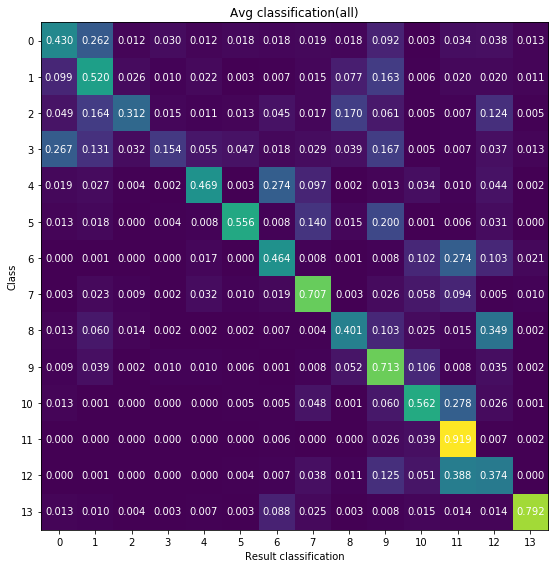

# Выгрузка результатов

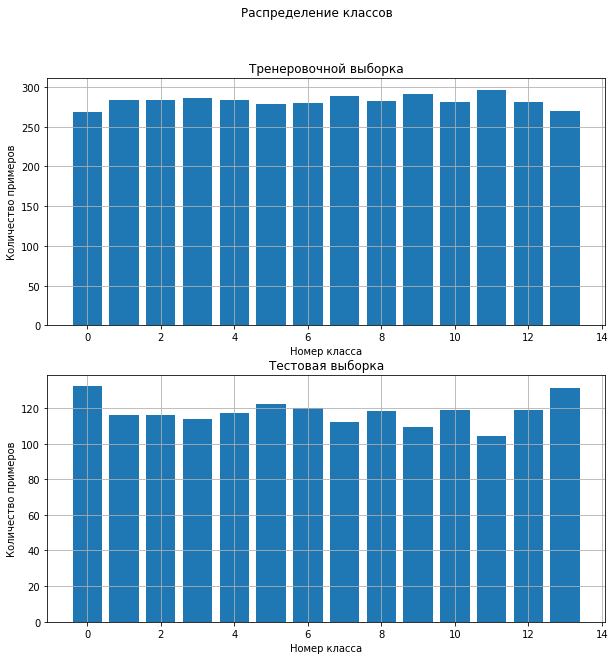

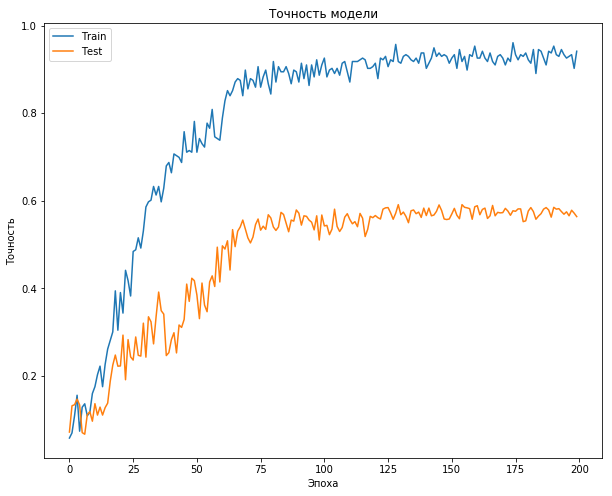

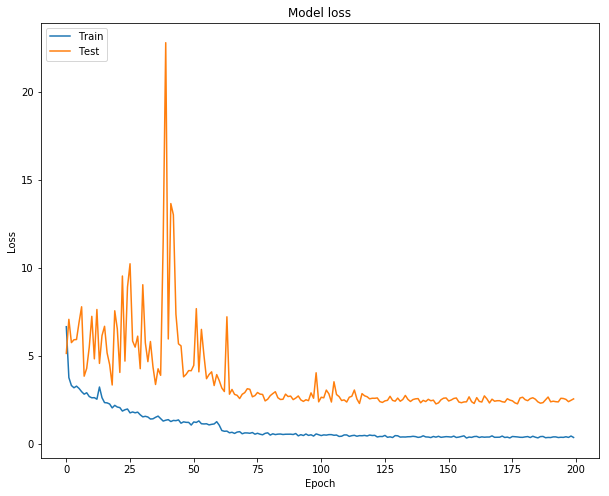

In [0]:
from zipfile import ZipFile
import os
from shutil import copyfile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from keras.models import load_model
model.save(EXPEREMENT_PATH + 'model.h5')

# build graphics
import matplotlib.pyplot as plt
from functools import reduce


# Количество примеров в каждом классе
fig, (ax0, ax1) = plt.subplots(nrows=2)
fig.set_size_inches((10, 10))
fig.suptitle("Распределение классов")

classData = np.zeros((1, COUNT_GUESTURE))
for i in trainDataset:
    _, y = i
    classData += y
classData = classData.reshape(COUNT_GUESTURE)
ax0.bar(range(COUNT_GUESTURE), classData)
ax0.set_xlabel('Номер класса')
ax0.set_ylabel('Количество примеров')
ax0.set_title('Тренеровочной выборка')
ax0.grid(True)

classData = np.zeros((1, COUNT_GUESTURE))
for i in testDataset:
    _, y = i
    classData += y
classData = classData.reshape(COUNT_GUESTURE)
ax1.bar(range(COUNT_GUESTURE), classData)
ax1.set_xlabel('Номер класса')
ax1.set_ylabel('Количество примеров')
ax1.set_title('Тестовая выборка')
ax1.grid(True)
plt.savefig(EXPEREMENT_PATH + 'classesCount.png')
plt.show()

# Точность
fig, ax0 = plt.subplots()
fig.set_size_inches((10, 8))
ax0.plot(history.history['acc'])
ax0.plot(history.history['val_acc'])
ax0.set_title('Точность модели')
ax0.set_ylabel('Точность')
ax0.set_xlabel('Эпоха')
ax0.legend(['Train', 'Test'], loc='upper left')
plt.savefig(EXPEREMENT_PATH + 'acc.png')
plt.show()

# График функции потери
fig, ax0 = plt.subplots()
fig.set_size_inches((10, 8))
ax0.plot(history.history['loss'])
ax0.plot(history.history['val_loss'])
ax0.set_title('Model loss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax0.legend(['Train', 'Test'], loc='upper left')
plt.savefig(EXPEREMENT_PATH + 'loss.png')
plt.show()

# Матрица среднии значения классификации
predicts = model.predict_generator(testDataset)
classes = [c.argmax() for d, c in  testDataset]
mat = [[] for i in range(COUNT_GUESTURE)]
for i in range(len(classes)):
    mat[classes[i]].append(predicts[i,:])
mat = list(map(np.array, mat))
mat = [ x.mean(axis=0) for x in mat ]
classes = list(range(COUNT_GUESTURE))
fig, ax = plt.subplots()
im = ax.imshow(mat)
fig.set_size_inches((10, 8))
# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel("Result classification")
ax.set_ylabel("Class")
# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, "%.3f" % mat[i][j],
                       ha="center", va="center", color="w")
ax.set_title("Avg classification(all)")
fig.tight_layout()
plt.savefig(EXPEREMENT_PATH + 'classMat.png')
plt.show()

# Create README
readmeText = "# %s\n"%EXPEREMENT_NAME
readmeText += "| Кол-во жестов | Обучающая выборка | Тестовая выборка | Количество эпох | Размер эпохи | Random seed | Dataset |\n"
readmeText += "| ------------- | ----------------- | ---------------- | --------------- | ------------ | ----------- | ------- |\n"
readmeText += "| %i | %i | %i | %i | %i | %i | %s |\n\n"%(COUNT_GUESTURE, 
                                                               len(trainDataset), 
                                                               len(testDataset),
                                                          EPOCH_COUNT,
                                                          EPOCH_SIZE,
                                                          RANDOM_SEED,
                                                          DATASET_NAME)
readmeText += "![](classesCount.png)\n"
readmeText += "## Результаты\n"
readmeText += "### Точность\n"
readmeText += "![](acc.png)\n"
readmeText += "### Функция потерь\n"
readmeText += "![](loss.png)\n"
readmeText += "### Качество классификации по классам\n"
readmeText += "![](classMat.png)\n"

with open(EXPEREMENT_PATH + "README.md", "w") as readmeFile:
    readmeFile.write(readmeText)
    
copyfile(DATASET_AUG_ROOT + "settings.json", EXPEREMENT_PATH + "augSettings.json")
copyfile(DATASET_CENTERED_ROOT + "settings.json", EXPEREMENT_PATH + "centeredSettings.json")

file = drive.CreateFile({'id': "1At4ILbV0Kcx6SnRi8hLq94TiFkab2ATu"})
file.GetContentFile(EXPEREMENT_PATH + "notebook.ipynb")

with ZipFile(ZIP_NAME, 'w') as z:
    for root, dirs, files in os.walk(EXPEREMENT_PATH):
        for file in files:
            z.write(os.path.join(root,file))
            
file = drive.CreateFile()
file.SetContentFile(ZIP_NAME)
file.Upload()